In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime

BASE_DIR = os.path.dirname(os.path.abspath(''))
DATA_DIR = os.path.join(BASE_DIR, 'data')
DATA_DIR_RAW = os.path.join(DATA_DIR, 'raw')
DATA_DIR_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_DIR_FINAL = os.path.join(DATA_DIR, 'final')

INPUT_CSV_FILENAME = '2019_Net_Generation_PSCO.csv'

In [7]:
input_gen_df = pd.read_csv(os.path.join(DATA_DIR_RAW, INPUT_CSV_FILENAME))

# read_csv grabs a few rows below last row w actual data. drop these rows
input_gen_df = input_gen_df.dropna(how='all')
interim_gen_df = input_gen_df.copy()

In [8]:
DATETIME_COLNAME = 'Date'
LOAD_COLNAME = 'Load'
COAL_COLNAME = 'Coal'
NG_COLNAME = 'Gas'
HYDRO_COLNAME = 'Hydro'
WIND_COLNAME = 'Wind'
SOLAR_COLNAME = 'Solar'

interim_gen_df[DATETIME_COLNAME] = pd.to_datetime(interim_gen_df[DATETIME_COLNAME])
interim_gen_df.head()

,Date,Load,Coal,Gas,Hydro,Wind,Solar
0,2019-01-01 00:00:00,4234.0,2109.0,688.0,8.0,1429.0,0.0
1,2019-01-01 01:00:00,3983.0,2136.0,777.0,8.0,1062.0,0.0
2,2019-01-01 02:00:00,3844.0,2150.0,899.0,7.0,788.0,0.0
3,2019-01-01 03:00:00,3753.0,2158.0,946.0,8.0,641.0,0.0
4,2019-01-01 04:00:00,3725.0,2262.0,1018.0,7.0,438.0,0.0


### Question 1: 
Create stacked area chart for each of the following days:
* April 8, 2019 (Monday)
* May 4, 2019 (Saturday)
* August 20, 2019 (Tuesday)
* November 27, 2019 (Wednesday)

In [103]:
sns.set(rc={'figure.figsize':(18, 6)})
plt.rc('legend',fontsize=16) 

def build_stack_chart(month, day, yr, input_df, solar_colname=SOLAR_COLNAME, coal_colname=COAL_COLNAME, ng_colname = NG_COLNAME):
    
    
    dt = datetime.date(yr, month, day)
    day_of_wk = dt.strftime('%A')
    plt_title = "Generation on {}/{}/{} ({})".format(month, day, yr, day_of_wk)
    df = input_df[
        (input_df[DATETIME_COLNAME].dt.date > dt - datetime.timedelta(days=1)) & 
        (input_df[DATETIME_COLNAME].dt.date < dt + datetime.timedelta(days=1))
    ].reset_index(drop=True)

    fig = plt.figure()
    area_ch_subplot_ax = fig.add_subplot(1, 1, 1)    

    pal = [
            "#000000", # coal
            "#5b8269", # ng
            "#5c5e32", # hydro
            "#3e61ed", # wind
            "#e69515" # solar
    ]

    plt.stackplot(df.index, \
              df[coal_colname], df[ng_colname], df[HYDRO_COLNAME], df[WIND_COLNAME], df[solar_colname], \
              labels=[COAL_COLNAME, NG_COLNAME, HYDRO_COLNAME, WIND_COLNAME, SOLAR_COLNAME], alpha=0.4, colors=pal )

    plt.ylabel("Generation (MW)", family='monospace' ,fontsize="x-large")
    plt.xlabel("Hour", family='serif', fontsize="x-large")
    plt.xticks(fontsize=13, family='monospace' ) # Rotate ticks. Doesn't look great, imo: rotation = 15, ha='right'
    plt.yticks(fontsize=13, family='monospace' )
    plt.ylim(ymin=0, ymax = 7500) # 7500 = Max generation
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'family': 'monospace'})
    plt.title(plt_title, family='serif', fontdict={"fontweight": "bold", "size": 20})
    plt.show()
    
    return

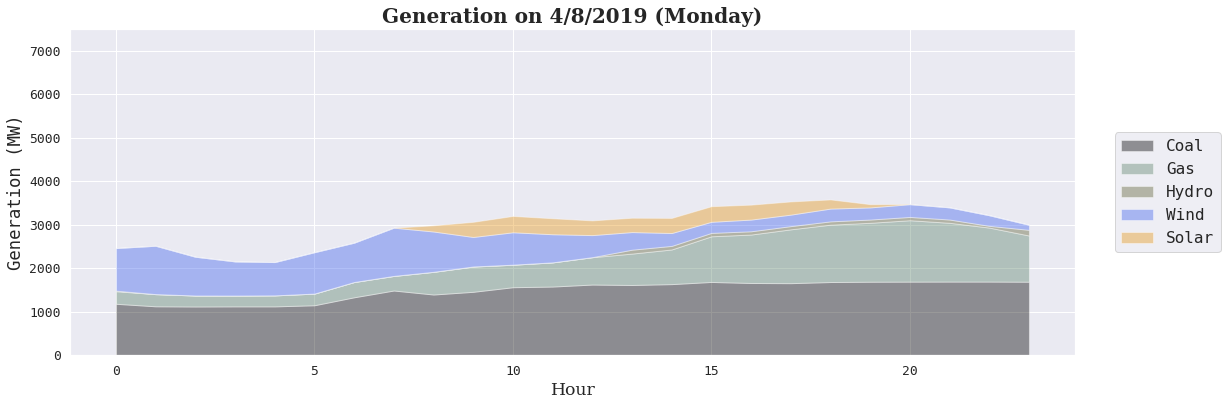

In [71]:
build_stack_chart(4, 8, 2019, interim_gen_df)

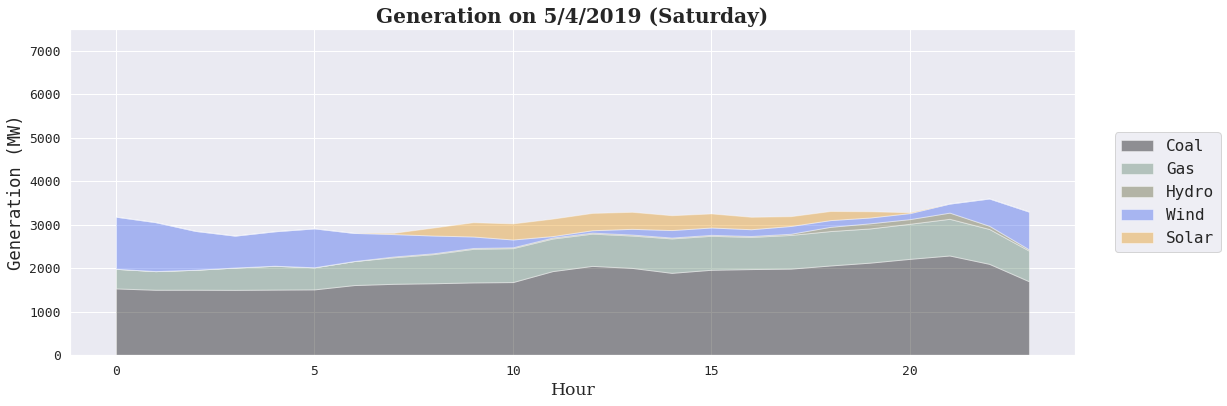

In [72]:
build_stack_chart(5, 4, 2019, interim_gen_df)

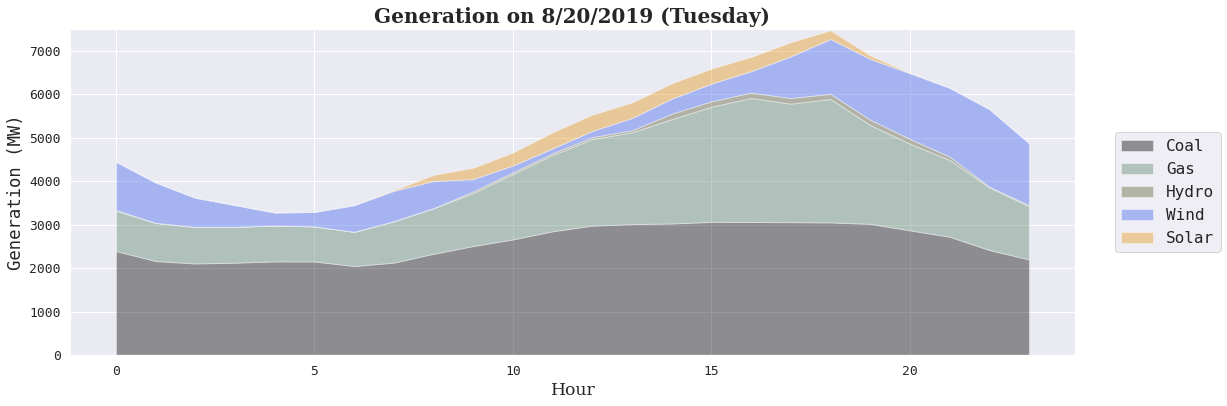

In [73]:
build_stack_chart(8, 20, 2019, interim_gen_df)

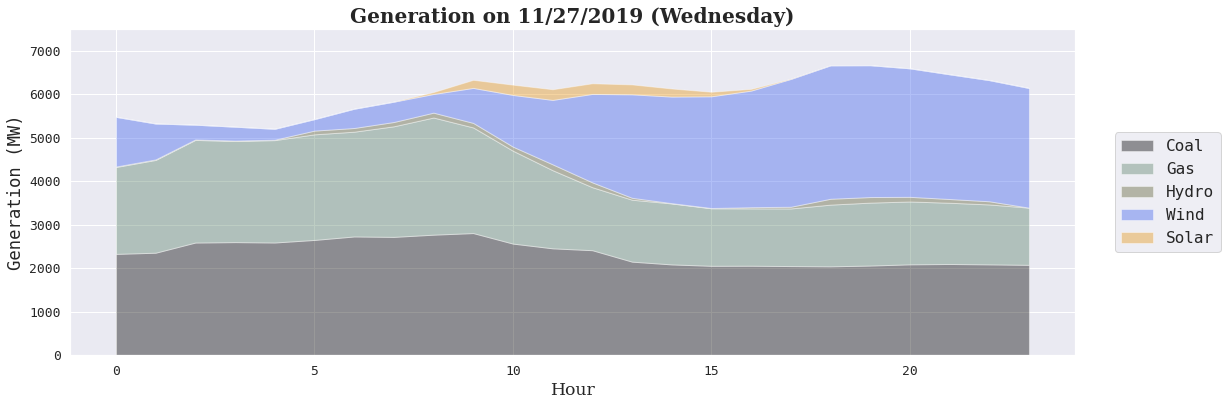

In [74]:
build_stack_chart(11, 27, 2019, interim_gen_df)

### Question 2
Increase the amount of solar energy to be 10% of the annual energy and replot the data for April 8.
* Plot the new stacked area chart
* Curtail non-renewable generation at appropriate levels (discuss)
* Discuss what issues might occur in a power system with this much solar on this day?

In [75]:
q2_df = interim_gen_df.copy()

sums = q2_df.sum()
factor_10_perc = .1 / (sums[SOLAR_COLNAME] / sums[LOAD_COLNAME])

In [95]:
SOLAR_10P_COLNAME = '{}_10_percent'.format(SOLAR_COLNAME)
SOLAR_20P_COLNAME = '{}_20_percent'.format(SOLAR_COLNAME)
COAL_10P_COLNAME = '{}_factored_10_percent_solar'.format(COAL_COLNAME)
COAL_20P_COLNAME = '{}_factored_20_percent_solar'.format(COAL_COLNAME)
NG_10P_COLNAME = '{}_factored_10_percent_solar'.format(NG_COLNAME)
NG_20P_COLNAME = '{}_factored_20_percent_solar'.format(NG_COLNAME)

q2_df[SOLAR_10P_COLNAME] = q2_df[SOLAR_COLNAME] * factor_10_perc

def get_conventional_gen_factored_col(row, perc, gen_col):
    
    col_config_object = {
        "coal": COAL_COLNAME,
        "gas" : NG_COLNAME
    }
    
    actual_gen_colname = col_config_object[gen_col]
    solar_col = SOLAR_10P_COLNAME if perc == 10 else SOLAR_20P_COLNAME
    
    addtl_solar = row[solar_col] - row[SOLAR_COLNAME] # factored col - actual solar gen
    gen_delta = row[actual_gen_colname] - addtl_solar
    curtailed_nonfossil_gen = 0 if gen_delta < 0 else gen_delta
    dt = datetime.date(2019, 4, 8)
#     if row[DATETIME_COLNAME].date() == dt:
#         print("\nrow[actual_gen_colname]: {}".format(row[actual_gen_colname]))
#         print("addtl_solar: {}".format(addtl_solar))
#         print("gen_delta: {}".format(gen_delta))
#         print("curtailed_nonfossil_gen: {}".format(curtailed_nonfossil_gen))
#         print("row[actual_gen_colname] - curtailed_nonfossil_gen: {}".format(row[actual_gen_colname] - curtailed_nonfossil_gen))
    return curtailed_nonfossil_gen

q2_df[COAL_10P_COLNAME] = q2_df.apply(
    lambda x: get_conventional_gen_factored_col(x, 10, "coal"), axis = 1
)


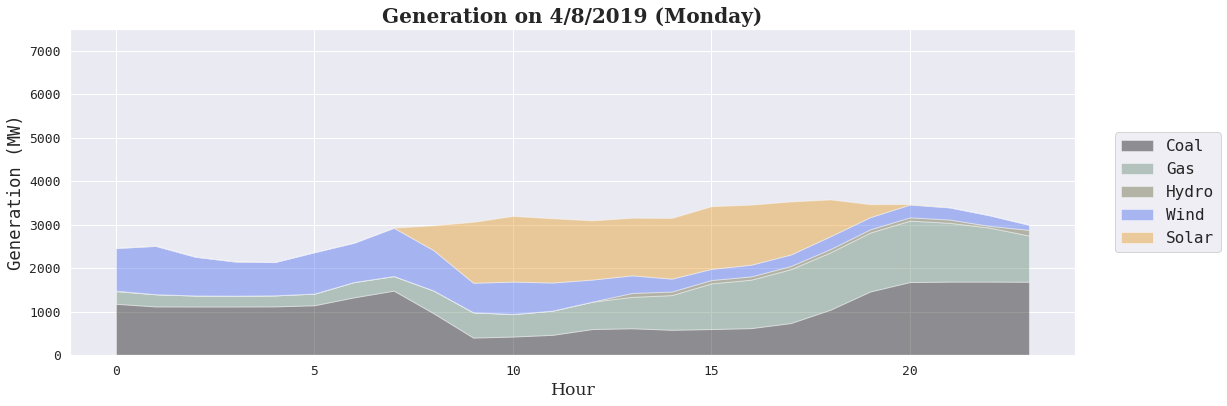

In [82]:
build_stack_chart(4, 8, 2019, q2_df ,solar_colname=SOLAR_10P_COLNAME, coal_colname=COAL_10P_COLNAME)

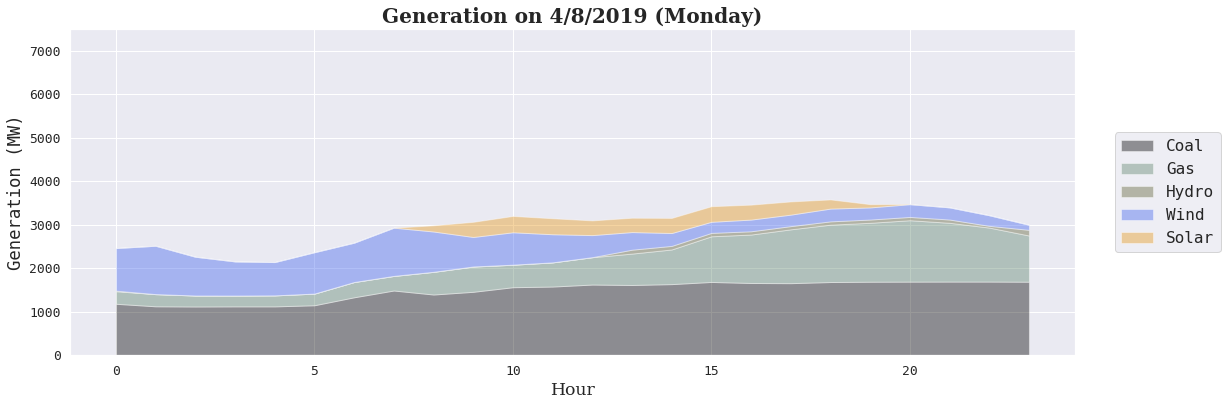

In [83]:
build_stack_chart(4, 8, 2019, interim_gen_df)

### Question 3
Increase the amount of solar energy to be 20% of the annual energy and replot the data for April 8.

In [84]:
q3_df = q2_df.copy()

sums = q3_df.sum()
factor_20_perc = .2 / (sums[SOLAR_COLNAME] / sums[LOAD_COLNAME])

In [86]:
q3_df[SOLAR_20P_COLNAME] = q3_df[SOLAR_COLNAME] * factor_20_perc

In [93]:
q3_df = q3_df[q3_df[DATETIME_COLNAME].dt.date == dt]

q3_df[COAL_20P_COLNAME] = q3_df.apply(
    lambda x: get_conventional_gen_factored_col(x, 20, "coal"), axis = 1
)


<ipython-input-93-5bfc4c09e7d9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q3_df[COAL_20P_COLNAME] = q3_df.apply(


In [101]:
remaining_load = q3_df[LOAD_COLNAME] - q3_df[HYDRO_COLNAME] - q3_df[WIND_COLNAME] - q3_df[SOLAR_20P_COLNAME] - q3_df[COAL_20P_COLNAME]
q3_df[NG_20P_COLNAME] = \
    q3_df[LOAD_COLNAME] - q3_df[HYDRO_COLNAME] - q3_df[WIND_COLNAME] - q3_df[SOLAR_20P_COLNAME] - q3_df[COAL_20P_COLNAME]

q3_df[NG_20P_COLNAME] = q3_df.apply(
    lambda x: x[NG_20P_COLNAME] if x[NG_20P_COLNAME] > 0 else 0,
    axis = 1
)



<ipython-input-101-4cbfe28d0431>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q3_df[NG_20P_COLNAME] = \
<ipython-input-101-4cbfe28d0431>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q3_df[NG_20P_COLNAME] = q3_df.apply(


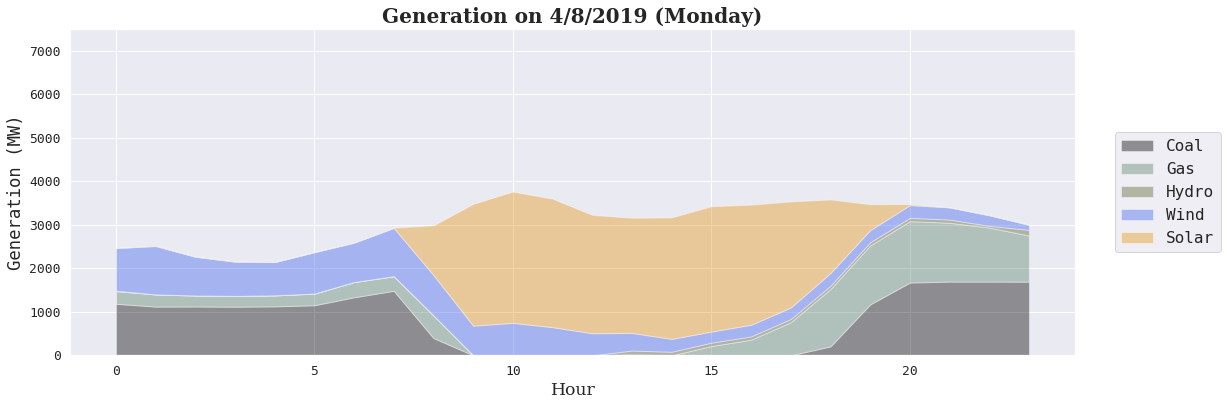

In [104]:
build_stack_chart(4, 8, 2019, q3_df, solar_colname=SOLAR_20P_COLNAME, coal_colname=COAL_20P_COLNAME, ng_colname=NG_20P_COLNAME)
